In [1]:
!nvidia-smi

Wed Oct  8 18:03:25 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   75C    P8             13W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
!pip -q install --upgrade pip
!pip -q install opencv-python pillow matplotlib albumentations tqdm einops

# (Colab ships with torch/torchvision; uncomment if you need a specific CUDA build)
# !pip -q install torch torchvision --index-url https://download.pytorch.org/whl/cu121

# Clone official MODNet
%cd /content
!git clone https://github.com/ZHKKKe/MODNet.git
%cd MODNet

/content
fatal: destination path 'MODNet' already exists and is not an empty directory.
/content/MODNet


In [3]:
# Robust loader: satisfies relative imports in MODNet without editing sys.path
import os, sys, types, importlib.util

repo_root = "/content/MODNet"
modnet_py = os.path.join(repo_root, "src", "models", "modnet.py")
bk_init   = os.path.join(repo_root, "src", "models", "backbones", "__init__.py")

# stub packages
pkg_src = types.ModuleType("src"); pkg_src.__path__ = [os.path.join(repo_root, "src")]
pkg_models = types.ModuleType("src.models"); pkg_models.__path__ = [os.path.join(repo_root, "src", "models")]
sys.modules["src"] = pkg_src
sys.modules["src.models"] = pkg_models

def _load(fullname, path):
    spec = importlib.util.spec_from_file_location(fullname, path)
    mod  = importlib.util.module_from_spec(spec)
    sys.modules[fullname] = mod
    spec.loader.exec_module(mod)
    return mod

# load backbones then modnet
_load("src.models.backbones", bk_init)
modnet_mod = _load("src.models.modnet", modnet_py)
MODNet = modnet_mod.MODNet

print("✅ MODNet loaded:", MODNet)


✅ MODNet loaded: <class 'src.models.modnet.MODNet'>


In [4]:
!mkdir -p /content/MODNet/pretrained
!wget -q https://github.com/ZHKKKe/MODNet/releases/download/v1/modnet_webcam_portrait_matting.ckpt \
    -O /content/MODNet/pretrained/modnet_webcam_portrait_matting.ckpt
print("✅ Pretrained model downloaded.")


✅ Pretrained model downloaded.


In [8]:
import torch
from pathlib import Path

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = MODNet(backbone_pretrained=False).to(device)   # we load the full ckpt next

from google.colab import drive
drive.mount('/content/drive')

ckpt_path = Path('/content/drive/MyDrive/modnet_data/pretrained//modnet_webcam_portrait_matting.ckpt')
state = torch.load(ckpt_path, map_location=device)
# Some releases wrap weights; some add "module." prefix
if isinstance(state, dict) and 'state_dict' in state:
    state = state['state_dict']
state = {k.replace('module.', ''): v for k, v in state.items()}

missing, unexpected = model.load_state_dict(state, strict=False)
print(f"🔧 Loaded pretrained. Missing: {len(missing)} | Unexpected: {len(unexpected)}")



Mounted at /content/drive
🔧 Loaded pretrained. Missing: 0 | Unexpected: 0


In [9]:
import cv2, numpy as np, glob, math, random
from pathlib import Path
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# ---- Paths (Drive assumed mounted already) ----
DATA_ROOT = Path('/content/drive/MyDrive/modnet_data')  # your converted AIM→MODNet dataset
TRAIN_IMG_DIR = DATA_ROOT/'train/images'
TRAIN_MAT_DIR = DATA_ROOT/'train/mattes'
VAL_IMG_DIR   = DATA_ROOT/'val/images'
VAL_MAT_DIR   = DATA_ROOT/'val/mattes'

for d in [TRAIN_IMG_DIR, TRAIN_MAT_DIR, VAL_IMG_DIR, VAL_MAT_DIR]:
    d.mkdir(parents=True, exist_ok=True)

print("Train imgs:", len(list(TRAIN_IMG_DIR.glob('*'))),
      "Train mattes:", len(list(TRAIN_MAT_DIR.glob('*'))))
print("Val imgs:", len(list(VAL_IMG_DIR.glob('*'))),
      "Val mattes:", len(list(VAL_MAT_DIR.glob('*'))))

IMG_EXT = {'.jpg','.jpeg','.png','.bmp','.webp'}

def alpha_to_trimap(alpha, ksize=(7,7), erode_iter=5, dilate_iter=5):
    """ alpha in 0..1 or 0..255 → trimap {0,128,255} """
    a = alpha.astype(np.float32)
    if a.max() <= 1.0: a = (a*255).astype(np.uint8)
    else: a = a.astype(np.uint8)

    fg = (a==255).astype(np.uint8)*255
    bg = (a==0).astype(np.uint8)*255
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, ksize)
    fg_erode = cv2.erode(fg, kernel, iterations=erode_iter)
    bg_dilate = cv2.erode(bg, kernel, iterations=dilate_iter)

    tri = np.full_like(a, 128, dtype=np.uint8)
    tri[bg_dilate==255] = 0
    tri[fg_erode==255] = 255
    return tri

def list_pairs(img_dir, mat_dir):
    pairs = []
    for p in sorted(img_dir.glob('*')):
        if p.suffix.lower() in IMG_EXT:
            mate = mat_dir / (p.stem + '.png')
            if not mate.exists():
                alt = mat_dir / (p.stem + '.jpg')
                if alt.exists(): mate = alt
            if mate.exists():
                pairs.append((p, mate))
    return pairs

class MattingDataset(Dataset):
    def __init__(self, img_dir, mat_dir, image_size=512, train=True):
        self.pairs = list_pairs(img_dir, mat_dir)
        self.train = train
        aug = []
        if train:
            aug += [
                A.HorizontalFlip(p=0.5),
                A.ShiftScaleRotate(0.02, 0.1, 10, p=0.5),
                A.ColorJitter(0.2,0.2,0.2,0.05, p=0.5),
            ]
        self.tfm = A.Compose(
            aug + [
                A.LongestMaxSize(max_size=image_size),
                A.PadIfNeeded(image_size, image_size, border_mode=cv2.BORDER_CONSTANT),
                A.Normalize(),
                ToTensorV2()
            ],
            additional_targets={'alpha':'mask','trimap':'mask'}
        )
    def __len__(self): return len(self.pairs)
    def __getitem__(self, idx):
        ip, mp = self.pairs[idx]
        img = cv2.cvtColor(cv2.imread(str(ip)), cv2.COLOR_BGR2RGB)
        alpha = cv2.imread(str(mp), cv2.IMREAD_UNCHANGED)
        if alpha is None:
            alpha = cv2.imread(str(mp), cv2.IMREAD_GRAYSCALE)
        if alpha.ndim==3: alpha = alpha[..., -1]
        alpha = alpha.astype(np.float32)
        if alpha.max()>1.0: alpha/=255.0
        alpha = np.clip(alpha,0,1)
        trimap = alpha_to_trimap(alpha)

        out = self.tfm(image=img, alpha=(alpha*255).astype(np.uint8), trimap=trimap)
        image = out['image']
        alpha_t = (out['alpha'].float()/255.0).unsqueeze(0)
        trimap_t = (out['trimap'].float()/255.0).unsqueeze(0)
        return {'image':image, 'alpha':alpha_t, 'trimap':trimap_t, 'name':ip.stem}

train_ds = MattingDataset(TRAIN_IMG_DIR, TRAIN_MAT_DIR, image_size=512, train=True)
val_ds   = MattingDataset(VAL_IMG_DIR,   VAL_MAT_DIR,   image_size=512, train=False)

train_loader = DataLoader(train_ds, batch_size=4, shuffle=True,  num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=4, shuffle=False, num_workers=2, pin_memory=True)

len(train_ds), len(val_ds)


Train imgs: 400 Train mattes: 400
Val imgs: 50 Val mattes: 50


/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


(400, 50)

In [10]:
import torch.nn as nn

def matting_loss(pred_alpha, gt_alpha):
    # L1 + gradient loss
    l1 = F.l1_loss(pred_alpha, gt_alpha)
    def grad(img):
        gx = img[:,:,:,1:] - img[:,:,:,:-1]
        gy = img[:,:,1:,:] - img[:,:,:-1,:]
        return gx, gy
    gx_p, gy_p = grad(pred_alpha)
    gx_g, gy_g = grad(gt_alpha)
    grad_l1 = F.l1_loss(gx_p, gx_g) + F.l1_loss(gy_p, gy_g)
    return l1 + 0.5*grad_l1

# Warmup: freeze backbone, train heads
for n,p in model.backbone.named_parameters():
    p.requires_grad = False

optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()),
                              lr=1e-4, weight_decay=1e-4)
UNFREEZE_EPOCH = 3


In [11]:
import torch.nn as nn

def matting_loss(pred_alpha, gt_alpha):
    # L1 + gradient loss
    l1 = F.l1_loss(pred_alpha, gt_alpha)
    def grad(img):
        gx = img[:,:,:,1:] - img[:,:,:,:-1]
        gy = img[:,:,1:,:] - img[:,:,:-1,:]
        return gx, gy
    gx_p, gy_p = grad(pred_alpha)
    gx_g, gy_g = grad(gt_alpha)
    grad_l1 = F.l1_loss(gx_p, gx_g) + F.l1_loss(gy_p, gy_g)
    return l1 + 0.5*grad_l1

# Warmup: freeze backbone, train heads
for n,p in model.backbone.named_parameters():
    p.requires_grad = False

optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()),
                              lr=1e-4, weight_decay=1e-4)
UNFREEZE_EPOCH = 3


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

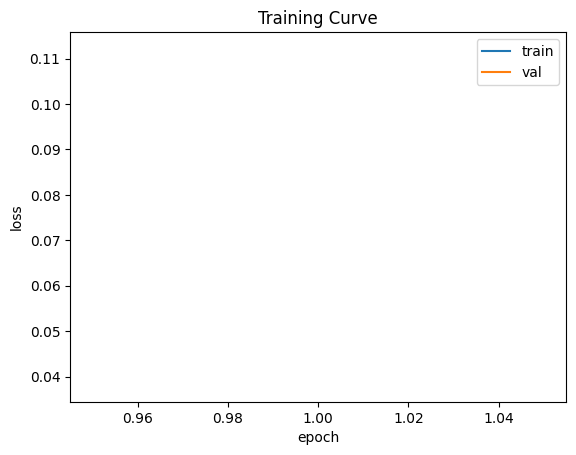

✅ Saved best @ epoch 1, val=0.0381 → /content/drive/MyDrive/modnet_runs/modnet_finetuned_best.pth


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

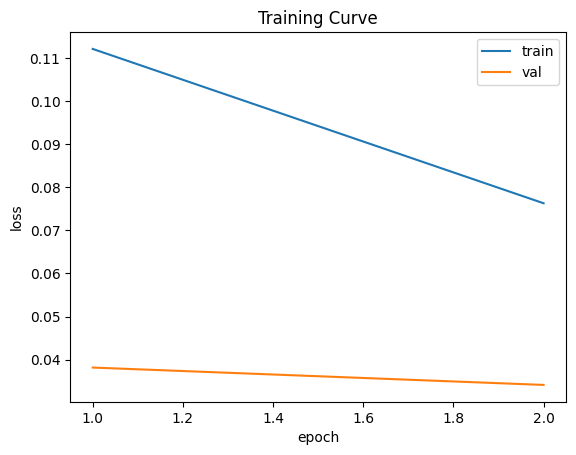

✅ Saved best @ epoch 2, val=0.0341 → /content/drive/MyDrive/modnet_runs/modnet_finetuned_best.pth
🔓 Unfroze backbone; lowered LR to 5e-5


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

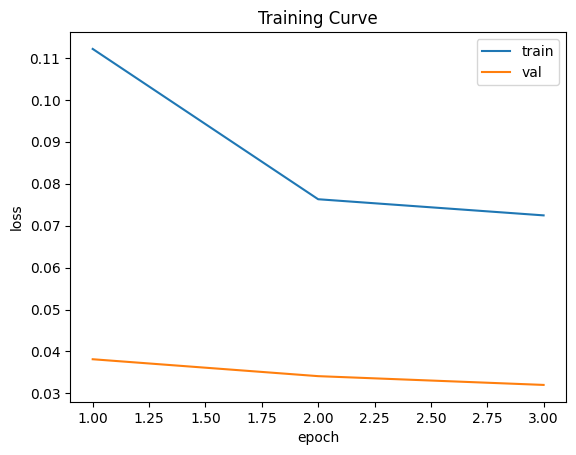

✅ Saved best @ epoch 3, val=0.0320 → /content/drive/MyDrive/modnet_runs/modnet_finetuned_best.pth


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

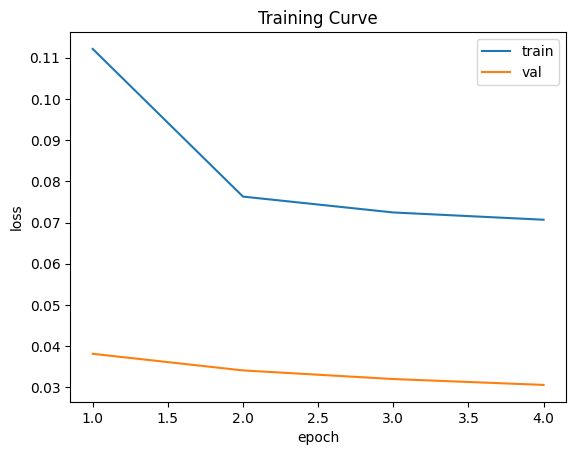

✅ Saved best @ epoch 4, val=0.0306 → /content/drive/MyDrive/modnet_runs/modnet_finetuned_best.pth


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

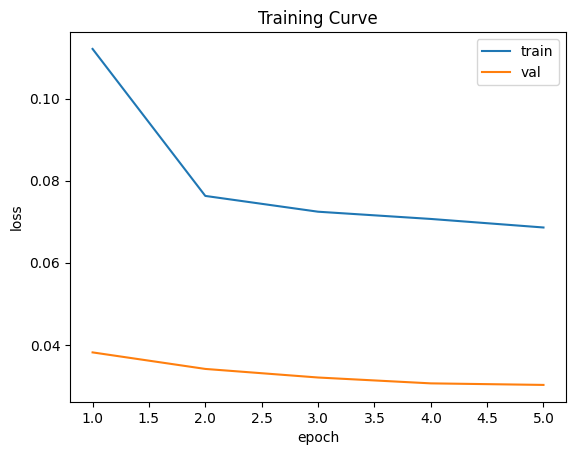

✅ Saved best @ epoch 5, val=0.0302 → /content/drive/MyDrive/modnet_runs/modnet_finetuned_best.pth


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

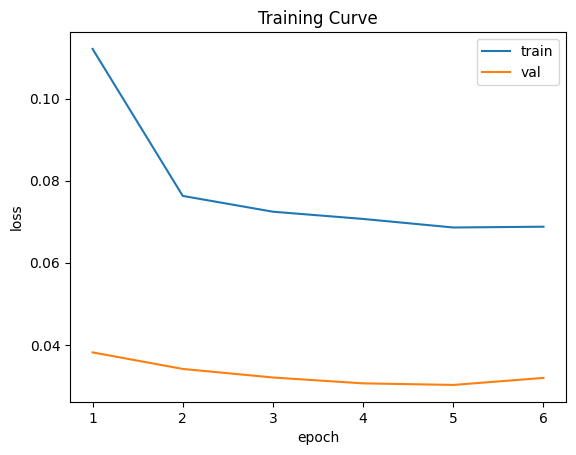

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

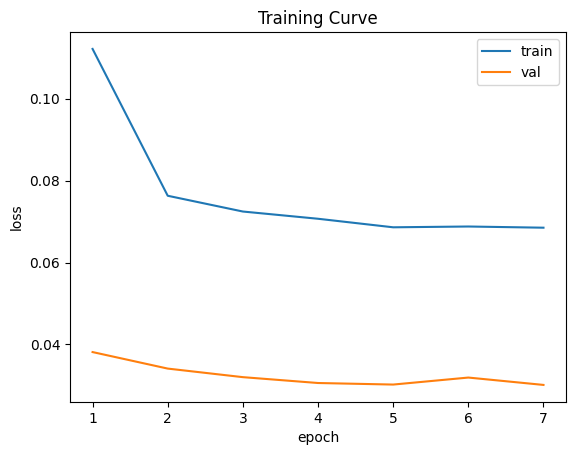

✅ Saved best @ epoch 7, val=0.0301 → /content/drive/MyDrive/modnet_runs/modnet_finetuned_best.pth


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

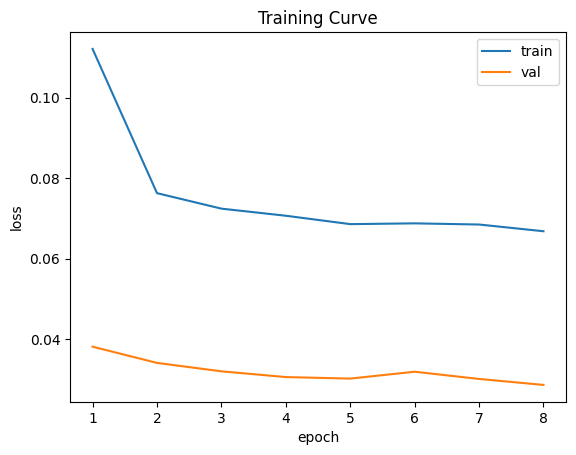

✅ Saved best @ epoch 8, val=0.0286 → /content/drive/MyDrive/modnet_runs/modnet_finetuned_best.pth


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

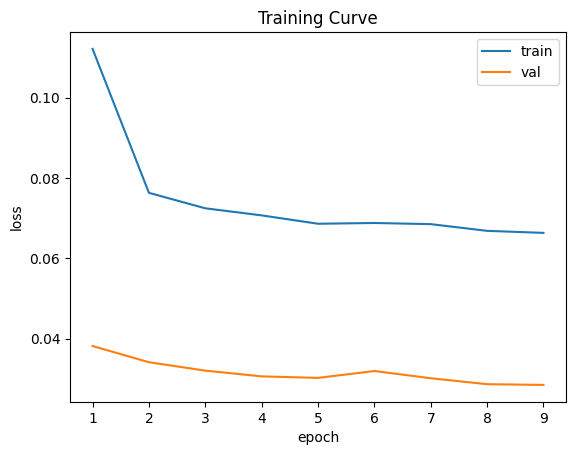

✅ Saved best @ epoch 9, val=0.0285 → /content/drive/MyDrive/modnet_runs/modnet_finetuned_best.pth


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

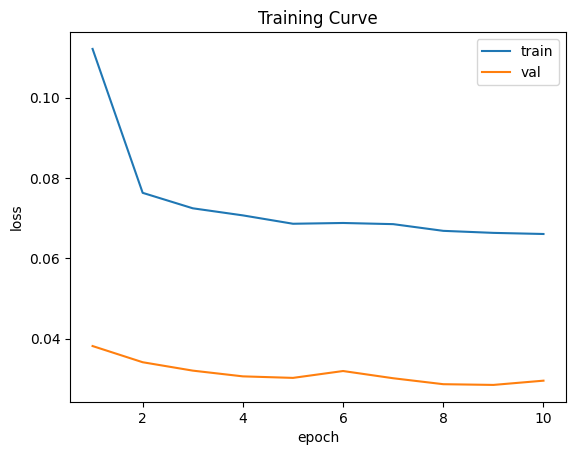

In [12]:
from pathlib import Path

def run_epoch(loader, training=True):
    model.train(mode=training)
    total, count = 0.0, 0
    pbar = tqdm(loader)
    for batch in pbar:
        image = batch['image'].to(device)
        alpha = batch['alpha'].to(device)
        if training: optimizer.zero_grad(set_to_none=True)
        # train mode returns tuple; eval may return tuple or tensor depending on flag
        pred_sem, pred_detail, pred_matte = model(image, True)  # True = training branch outputs
        loss = matting_loss(torch.clamp(pred_matte,0,1), alpha)
        if training:
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
        total += loss.item() * image.size(0)
        count += image.size(0)
        pbar.set_description(f"{'Train' if training else 'Val'} loss: {loss.item():.4f}")
    return total/max(count,1)

EPOCHS = 10
best_val = float('inf')
train_hist, val_hist = [], []

save_dir = Path('/content/drive/MyDrive/modnet_runs')
save_dir.mkdir(parents=True, exist_ok=True)
ckpt_path = save_dir/'modnet_finetuned_best.pth'

for epoch in range(1, EPOCHS+1):
    if epoch == UNFREEZE_EPOCH:
        for p in model.backbone.parameters():
            p.requires_grad = True
        optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=1e-4)
        print("🔓 Unfroze backbone; lowered LR to 5e-5")

    tl = run_epoch(train_loader, True)
    vl = run_epoch(val_loader,   False)

    train_hist.append(tl); val_hist.append(vl)

    # live plot
    plt.figure()
    plt.plot(range(1,len(train_hist)+1), train_hist, label='train')
    plt.plot(range(1,len(val_hist)+1),   val_hist,   label='val')
    plt.xlabel('epoch'); plt.ylabel('loss'); plt.title('Training Curve'); plt.legend()
    plt.show()

    if vl < best_val:
        best_val = vl
        torch.save({'epoch': epoch,
                    'model_state': model.state_dict(),
                    'opt_state': optimizer.state_dict(),
                    'val_loss': vl}, ckpt_path)
        print(f"✅ Saved best @ epoch {epoch}, val={vl:.4f} → {ckpt_path}")


✅ Loaded fine-tuned checkpoint (epoch 9, val=0.0285)


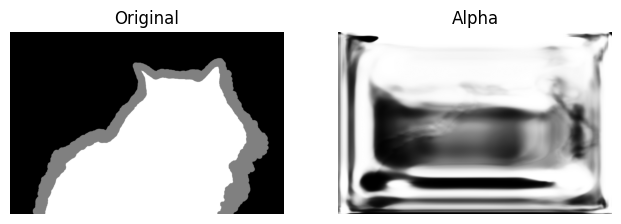

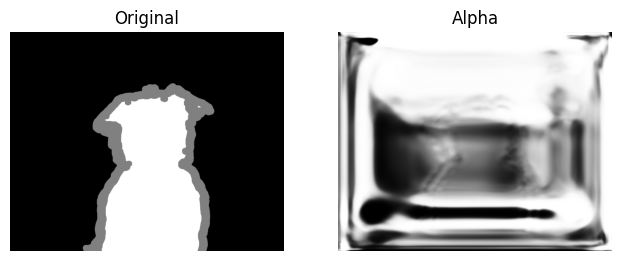

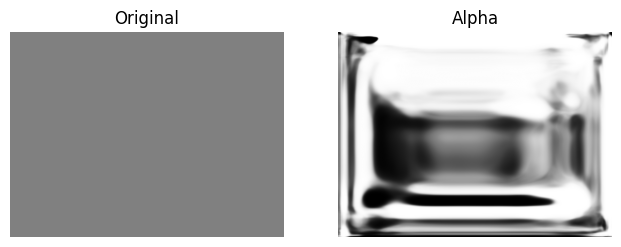

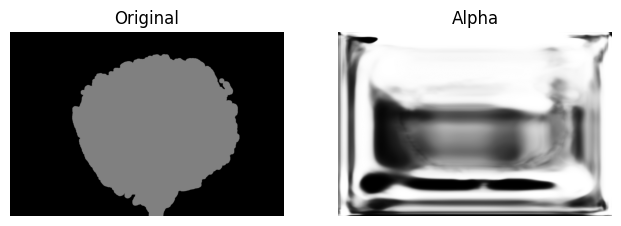

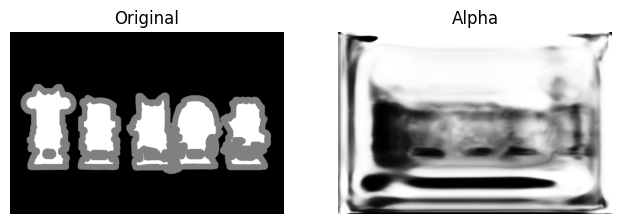

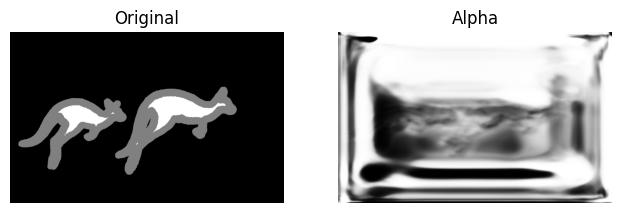

📁 Saved to: /content/drive/MyDrive/modnet_runs/predictions_ft


In [13]:
import albumentations as A

@torch.no_grad()
def infer_alpha(model, img_bgr, device, image_size=512):
    model.eval()
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    h, w = img_rgb.shape[:2]
    tfm = A.Compose([
        A.LongestMaxSize(max_size=image_size),
        A.PadIfNeeded(image_size, image_size, border_mode=cv2.BORDER_CONSTANT),
        A.Normalize()
    ])
    x = tfm(image=img_rgb)['image']
    x = torch.from_numpy(x.transpose(2,0,1)).float().unsqueeze(0)/255.0
    x = x.to(device)
    # Inference: prefer inference=True; fallback to False
    try:
        out = model(x, inference=True)
    except TypeError:
        out = model(x, False)
    if isinstance(out, (tuple, list)):
        matte = out[-1]
    else:
        matte = out
    matte = matte[0,0].cpu().numpy()
    matte = cv2.resize(matte, (w,h), interpolation=cv2.INTER_CUBIC)
    return np.clip(matte,0,1)

def composite(fg_bgr, alpha, bg_bgr):
    h,w = fg_bgr.shape[:2]
    bg = cv2.resize(bg_bgr, (w,h), interpolation=cv2.INTER_AREA)
    a = alpha[...,None]
    comp = a*fg_bgr.astype(np.float32) + (1-a)*bg.astype(np.float32)
    return np.clip(comp,0,255).astype(np.uint8)

# Load fine-tuned best
ckpt = torch.load(ckpt_path, map_location=device)
model.load_state_dict(ckpt['model_state'])
model.eval()
print(f"✅ Loaded fine-tuned checkpoint (epoch {ckpt['epoch']}, val={ckpt['val_loss']:.4f})")

# Optional background directory
BG_DIR = DATA_ROOT/'bgs'
IMG_EXTS = {'.jpg','.jpeg','.png','.bmp','.webp'}
bg_paths = sorted([p for p in BG_DIR.glob('*') if p.suffix.lower() in IMG_EXTS]) if BG_DIR.exists() else []
bg_img = cv2.imread(str(bg_paths[0])) if bg_paths else None

# Test few images from val/images
preview_dir = save_dir/'predictions_ft'
preview_dir.mkdir(parents=True, exist_ok=True)
samples = sorted([p for p in (DATA_ROOT/'val/images').glob('*') if p.suffix.lower() in IMG_EXTS])[:6]

for p in samples:
    bgr = cv2.imread(str(p))
    alpha = infer_alpha(model, bgr, device, 512)
    cv2.imwrite(str(preview_dir/(p.stem+'_alpha.png')), (alpha*255).astype(np.uint8))
    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1); plt.title('Original'); plt.axis('off'); plt.imshow(cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB))
    plt.subplot(1,3,2); plt.title('Alpha');    plt.axis('off'); plt.imshow(alpha, cmap='gray')
    if bg_img is not None:
        comp = composite(bgr, alpha, bg_img)
        cv2.imwrite(str(preview_dir/(p.stem+'_comp.png')), comp)
        plt.subplot(1,3,3); plt.title('Composite'); plt.axis('off'); plt.imshow(cv2.cvtColor(comp, cv2.COLOR_BGR2RGB))
    plt.show()

print("📁 Saved to:", preview_dir)


In [14]:
# Load and continue fine-tuning at a smaller LR
ckpt = torch.load(ckpt_path, map_location=device)
model.load_state_dict(ckpt['model_state'])
optimizer.load_state_dict(ckpt['opt_state'])
for g in optimizer.param_groups:
    g['lr'] = 3e-5
print("↩️ Resumed. New LR=3e-5")


↩️ Resumed. New LR=3e-5
